## Device code version 2.0

Demo data is available within the [device-data-plotting](https://github.com/EJCassella/Device-data-plotting) repo.

In the user inputs section below, define the data filters and the data you want to plot / save, then run the whole code.

To alter the data filters or graph axes after selecting your data, re-run the user inputs cell (click in the cell and Ctrl + enter), then re run ONLY the cells to "apply filters to data", and then the "make boxplots and output statistics" cell. 

If you rerun the data selection cell you gotta go back through the whole process.

If you find any bugs / issues let me know and i'll do my best to fix things ASAP. Similarly, if there are any other features that you'd find useful let me know
and i'll build on this.

This code could definitely be tidier, and will be refactored at a later date.

🏆 Happy plotting!


### Function importing
Also using the Jupyter Notebook magic command to run the .ipynb containing our function definitions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from tkinter import Tk
from tkinter import filedialog
%run functions.ipynb

---
# User Inputs 👇

In [76]:
""" Filter options """
spec_num = 0 #number > 0 is on and will plot n number of data points from each sweep dataset
percentage_filtered = 0 #Does what is says on the tin
PCE_filt = (0,  25) #first number is the lower cut-off, second number is the upper cut-off
Jsc_filt =  (0, 25) #first number is the lower cut-off, second number is the upper cut-off
Voc_filt = (0, 1.2) #first number is the lower cut-off, second number is the upper cut-off
FF_filt = (0, 85) #first number is the lower cut-off, second number is the upper cut-off
""" Filter options """

""" Plot JVs on or off """
plot_JVs = 1 #1 is on! This will plot a JV curve for each pixel for each substrate selected
""" Plot JVs on or off """

""" Plot boxplots on or off """
plot_boxplots = 1 #1 is on! This will plot the boxplots of data. If this isn't on, no statistics will be outputted
save_boxplots = 1 #1 is on! Does what it says on the tin
plot_sweeps_seperately = 1 #1 is on! Forward sweep will be filled circles, backwards will be circle outlines only. For OPV version just turn this off if you wanna

plot_title = 'my_awesome_devices'  #This will name the outputted png file of the boxplots
""" Plot boxplots on or off """

""" Controls to plot reverse data only """
plot_reverse_sweep_only = 0 #1 is on! If you want to get rid of your shitty forward sweeps turn this on 
plot_JV_reverse_only = 0 #1 is on! plot_JVs must also be on to actually plot them up
""" Controls to plot reverse data only """


add_distribution_to_plot = 1 #1 is on! This will overlay a violin plot on the boxplots to illustrate distribution and look pretty!
record_statistics_of_filtered_data = 1 #1 is on! Turn on if you want an outputted .csv file with the stats of the selected splits. Will save with identical name to the boxplot for ease of location

PCElimits= (0, 22) #Axis limits for PCE plot
Jsclimits = (00, 25) #Axis limits for Jsc plot
Voclimits = (0.8, 1.2) #Axis limits for Voc plot
FFlimits = (0, 90) #Axis limits for FF pot




# User Inputs ☝
---

If you change any code below this line, do so at your own peril!


___
⛔ Once you have selected your data, don't re-run the cell below if you change your filters or axes limits, else will then have to redefine your groups and reselect your data. ⛔
---
---

## This is where the magic happens!
### Pick where to save your data, define your groups/splits and select your data
You will be asked for three (or four) inputs:
1. What directory should outputs be saved into?
2. How many groups are there to plot?
3. Do you want to label the groups?
4. If yes, enter each group name and press enter

Next, tkinter will throw up a file dialog for you to navigate to the data you want to include, looping through each group.

In [68]:
working_directory = input("Where should we output the data?")
os.chdir(str(working_directory)) 
cwd = os.getcwd()

check_plot_title(plot_title)

Groups = input("How many groups are there?\n") #the number of splits / seperate boxes

Groupnames = []
group_arrays = [ [] for i in range(int(Groups))]

Answer = input("Do you want to label the groups? (Y or N)\n").upper() 
if Answer == 'Y':
    for g in range (0, int(Groups)):
        Gpname = input("Split number " + str(g + 1) + ":\n")
        Groupnames.append(Gpname)
elif Answer == 'N':
    pass
   

for s in range (0, int(Groups)): #Pop up window that loops through groups
    print ("Select split number " + str(s+1))
    root = Tk()
    root.lift()
    root.withdraw()
    alldemfiles = filedialog.askopenfilenames(parent = root)
    alldemfileslist = root.tk.splitlist(alldemfiles)
    root.withdraw()
    Alljsc, Allvoc, AllFF,  AllPCE = ([], [], [], [])
    xvalues, yvalues = ([], [])
    
    for k in range (len(alldemfileslist)): #LOOPS THROUGH SUBS
        headers = ['Voltage (V)', 'Pixel 1', 'Pixel 2', 'Pixel 3', 'Pixel 4', 'Pixel 5', 'Pixel 6', 'Pixel 7', 'Pixel 8'] 
        df = pd.read_csv(alldemfileslist[k], skiprows = 2, skipfooter = 15, index_col = 0, names = headers, engine = 'python')
        df.iloc[:,0:]*= -1 #This bit flips the Jsc because Emma likes it positive, take it out if you want it as it is originally
        substrate = os.path.splitext(os.path.split(alldemfileslist[k]) [1])[0] #use to save a file name, not important
        substrate_array = np.zeros((8,12))
        pixels = 0  #Counting the pixels to loop through - this can then handle different pixel counts for mixed splits
        for ind,x in enumerate(df):
            if int(abs((df.iloc[:, ind]).sum()).sum()) == 0:
                pixels += 0
            else:
                pixels += 1
        for i in range(1, pixels+1): #LOOPS THROUGH PIXELS
            x = np.array(df.index.values) #voltage is x
            y = np.array(df[str(headers[i])].values) #current density is y
            xvalues.append(x)
            yvalues.append(y)
        #Parameters set up  
            xlist = np.split(x, 2) #splitting voltage into forward and backwards scans
            xfwd = xlist[0] #xfwd = forward voltage (0 to 1.2V)
            xbcwd = xlist[1] #xbcwd = backwards current (1.2 to 0V)
            ylist = np.split(y, 2) #doing the same for current
            yfwd = ylist[0]
            ybcwd = ylist[1]
            
        #FORWARDS- Jsc and Voc
            xifwd = np.linspace(0, 1.2, 10000) #array of 10000 numbers between 0 and 1.2 (voltage array)
            yifwd = np.interp(xifwd, xfwd, yfwd) #interpolates between x to get current array
            idxfwd = abs(xifwd).argmin() #row number of minimum absolute voltage value (0)
            jscfwd = yifwd[idxfwd] #jsc that corresponds to this    
            idyfwd = abs(yifwd).argmin() #row number of minimum absolute current value (0)
            if np.ptp(yifwd) <= 0.1: #sets up filter for shunts- if total current range is less than 0.1 mA
                vocfwd = 0
            else:
                vocfwd = xifwd[idyfwd] #voc that corresponds to this
        #BACKWARDS- Jsc and Voc
            xibcwd = np.flipud(xifwd)
            yb = np.flipud(ybcwd)
            yibcwd = np.flipud(np.interp(xifwd, xfwd, yb)) #interpolates between x and y based on new array
            idxbcwd = abs(xibcwd).argmin() #returns row number of minimum absolute voltage value (0)
            jscbcwd = yibcwd[idxbcwd] #jsc that corresponds to this (so just the first value)
            idybcwd = abs(yibcwd).argmin() #row number of minimum absolute current value (0)
            if np.ptp(yibcwd) <= 0.1: #sets up filter for shunts- if total current range is less than 0.1 mA then voc=0
                vocbcwd = 0
            else:
                vocbcwd = xibcwd[idybcwd] #voc that corresponds to this 
                
        #Fill Factor and PCE
            Pfwd = xifwd*yifwd
            idpfwd = list(Pfwd).index(Pfwd.max()) #maximum power point
            if jscfwd == 0 or vocfwd == 0: #set up filter to prevent division error- if Voc or Jsc are 0 then so is FF
                FFfwd = 0
                PCEfwd = 0
            else:
                FFfwd = (Pfwd[idpfwd]/(jscfwd*vocfwd))*100
                PCEfwd = jscfwd * vocfwd * (FFfwd/100)
                
            Pbcwd = xibcwd*yibcwd
            idpbcwd = list(Pbcwd).index(Pbcwd.max())
            if jscbcwd == 0 or vocbcwd == 0:
                FFbcwd  = 0
                PCEbcwd = 0
            else:
                FFbcwd = (Pbcwd[idpbcwd]/(jscbcwd*vocbcwd))*100
                PCEbcwd = jscbcwd * vocbcwd * (FFbcwd/100)
               
         #Vmpp and Jmpp
            Vmppfwd = xifwd[idpfwd]
            Jmppfwd = yifwd[idpfwd]  
            Vmppbcwd = xibcwd[idpbcwd]
            Jmppbcwd = yibcwd[idpbcwd]
            
        #average of sweeps UNFILTERED
            avgjsc = str(round((jscfwd + jscbcwd)/2,1))
            avgvoc = str(round((vocfwd + vocbcwd)/2,2))
            avgff = str(round((FFfwd + FFbcwd)/2,1))
            avgpce = str(round((PCEfwd + PCEbcwd)/2,1))
            
            roundjscfwd = str(round((jscfwd),2))
            roundvocfwd = str(round((vocfwd),2))
            roundfffwd = str(round((FFfwd),1))
            roundpcefwd = str(round((PCEfwd),1))
            
            roundjscbcwd = str(round((jscbcwd),2))
            roundvocbcwd = str(round((vocbcwd),2))
            roundffbcwd = str(round((FFbcwd),1))
            roundpcebcwd = str(round((PCEbcwd),1))
            
            if plot_JVs == 1:    
                make_output_path(cwd + "\\JV curves")
                make_output_path(cwd + "\\JV curves\\" + substrate)
                if plot_JV_reverse_only == 1:
                    JV_reverse_only()
                else:                    
                    plot_JV()
                plt.savefig(cwd + '\\JV curves\\' + substrate + '\\pixel' + str(i) + '.png') #transparent = True to export without background for posters etc.
                plt.close() 
            else:
                pass
                    
        #make a dictionary of parameter values
            device_parameters = {'PCEfwd': PCEfwd, 'PCEbcwd': PCEbcwd, 'jscfwd': jscfwd, 'jscbcwd': jscbcwd, 'vocfwd': vocfwd, 'vocbcwd': vocbcwd, 'FFfwd': FFfwd,'FFbcwd': FFbcwd,'Jmppfwd': Jmppfwd,'Jmppbcwd': Jmppbcwd,'Vmppfwd': Vmppfwd,'Vmppbcwd': Vmppbcwd}
            for d,key in enumerate(device_parameters):
                substrate_array[i-1,d] = device_parameters[key]
        
        if k == 0:
            group_arrays[s] = substrate_array
        else:
            group_arrays[s] = np.dstack((group_arrays[s], substrate_array)) #adding the data to 3d arrays

Where should we output the data?C:\Users\Elena\Desktop\test
How many groups are there?
1
Do you want to label the groups? (Y or N)
n
Select split number 1


---
⛔ Once you have selected your data, don't re-run the cell above if you change your filters or axes limits, else will then have to redefine your groups and reselect your data. ⛔
---
---

# 👇 Apply filters to data.
Here, we're applying filters to the data without changing the original data, so that we can change the filters on the fly.

---
🟢 Rerun this cell once you have changed your filters to update the data 🟢
---
---

In [ ]:
parameters_to_filter = [PCE_filt[0], PCE_filt[1], Jsc_filt[0], Jsc_filt[1], Voc_filt[0], Voc_filt[1], FF_filt[0], FF_filt[1]]
groups_filt_params = [([([]) for i in range(len(device_parameters))]) for i in range(int(Groups))]


for g, group in enumerate(group_arrays): #loop through group data cubes
    for ind, frame in enumerate(group_arrays[g]): #loop through slices of group data cube per pixel
        if len(frame.shape) == 1:
            subs_in_frame = 1
        else:
            subs_in_frame = frame.shape[-1]
        for y in range(subs_in_frame): #loop through number of pixels in each frame then test parameters against filters
            filtered_parameters = [[] for i in range(len(device_parameters))]
            if subs_in_frame == 1: #to handle case where there is only one substrate in the group and we can replace this with a function for tidiness
                fwd_filt_data = forward_sweep_filter(frame[:])
                bcwd_filt_data = backward_sweep_filter(frame[:])
                if fwd_filt_data is None or bcwd_filt_data is None:
                    continue
                else:
                    for i, value in enumerate(fwd_filt_data): #Elena should tidy this up into a function!!!!
                        if i == 0:
                           ind = 0     
                        else:
                           ind = i*2
                        if value == 0:
                            value = np.nan
                        else:
                            value = value
                        filtered_parameters[ind].append(value)
                    for i, value in enumerate(bcwd_filt_data):
                        if i == 0:
                            ind = 1     
                        else:
                            ind = i*2+1
                        if value == 0:
                            value = np.nan
                        else:
                            value = value
                        filtered_parameters[ind].append(value)
            else:
                fwd_filt_data = forward_sweep_filter(frame[:,y])
                bcwd_filt_data = backward_sweep_filter(frame[:,y])
                if fwd_filt_data is None or bcwd_filt_data is None:
                    continue
                else:
                    for i, value in enumerate(fwd_filt_data):
                        if i == 0:
                           ind = 0     
                        else:
                           ind = i*2
                        if value == 0:
                            value = np.nan
                        else:
                            value = value
                        filtered_parameters[ind].append(value)
                    for i, value in enumerate(bcwd_filt_data):
                       if i == 0:
                           ind = 1     
                       else:
                           ind = i*2+1
                       if value == 0:
                            value = np.nan
                       else:
                            value = value
                       filtered_parameters[ind].append(value)
        #We need to append these filtered parameters to an array per group
            for x, filt in enumerate(groups_filt_params[g]):
                groups_filt_params[g][x].extend(filtered_parameters[x])
                
" Remove NaN values from metric lists and add zeroes to empty lists so that python doesn't have an absolute meltdown "

for group, alldata in enumerate(groups_filt_params):
        for metric, groupdata in enumerate(groups_filt_params[group]):
            newlist = [x for x in groups_filt_params[group][metric] if x  == x]
            groups_filt_params[group][metric] = newlist

" If no values make it into the metric lists, populate with a zero so that python doesn't have another absolute meltdown"


for group, alldata in enumerate(groups_filt_params):
        for metric, groupdata in enumerate(groups_filt_params[group]):
            if groups_filt_params[group][metric] == []:
                groups_filt_params[group][metric] = [0]

               
" Percentage filter: can be turned off by setting to 0 in user inputs" 

if percentage_filtered > 0:        
    for group, alldata in enumerate(groups_filt_params):
        for metric, groupdata in enumerate(groups_filt_params[group]):
            threshold = np.percentile(groups_filt_params[group][metric],percentage_filtered)
            newlist = [x for x in groups_filt_params[group][metric] if x >= threshold]
            groups_filt_params[group][metric] = newlist
else:
    pass


""" To plot specific number of values from dataset
    n.b. that this is just the top n datapoints from the forward sweep data and the reverse sweep data,
    so not necessarily the top n 'devices. To be updated for proper functionality """

if spec_num > 0:
    for group, alldata in enumerate(groups_filt_params):
        for metric, groupdata in enumerate(groups_filt_params[group]):
            newlist = sorted(groups_filt_params[group][metric], reverse = True)[:spec_num]
            groups_filt_params[group][metric] = newlist
else:
    pass


# 📊 Make boxplots and output statistics
This section plots a boxplot of all metrics and calculates and records the statistics of the data that makes it through the filter. The outputted file will have an identical filename to the boxplots for easy identification
   

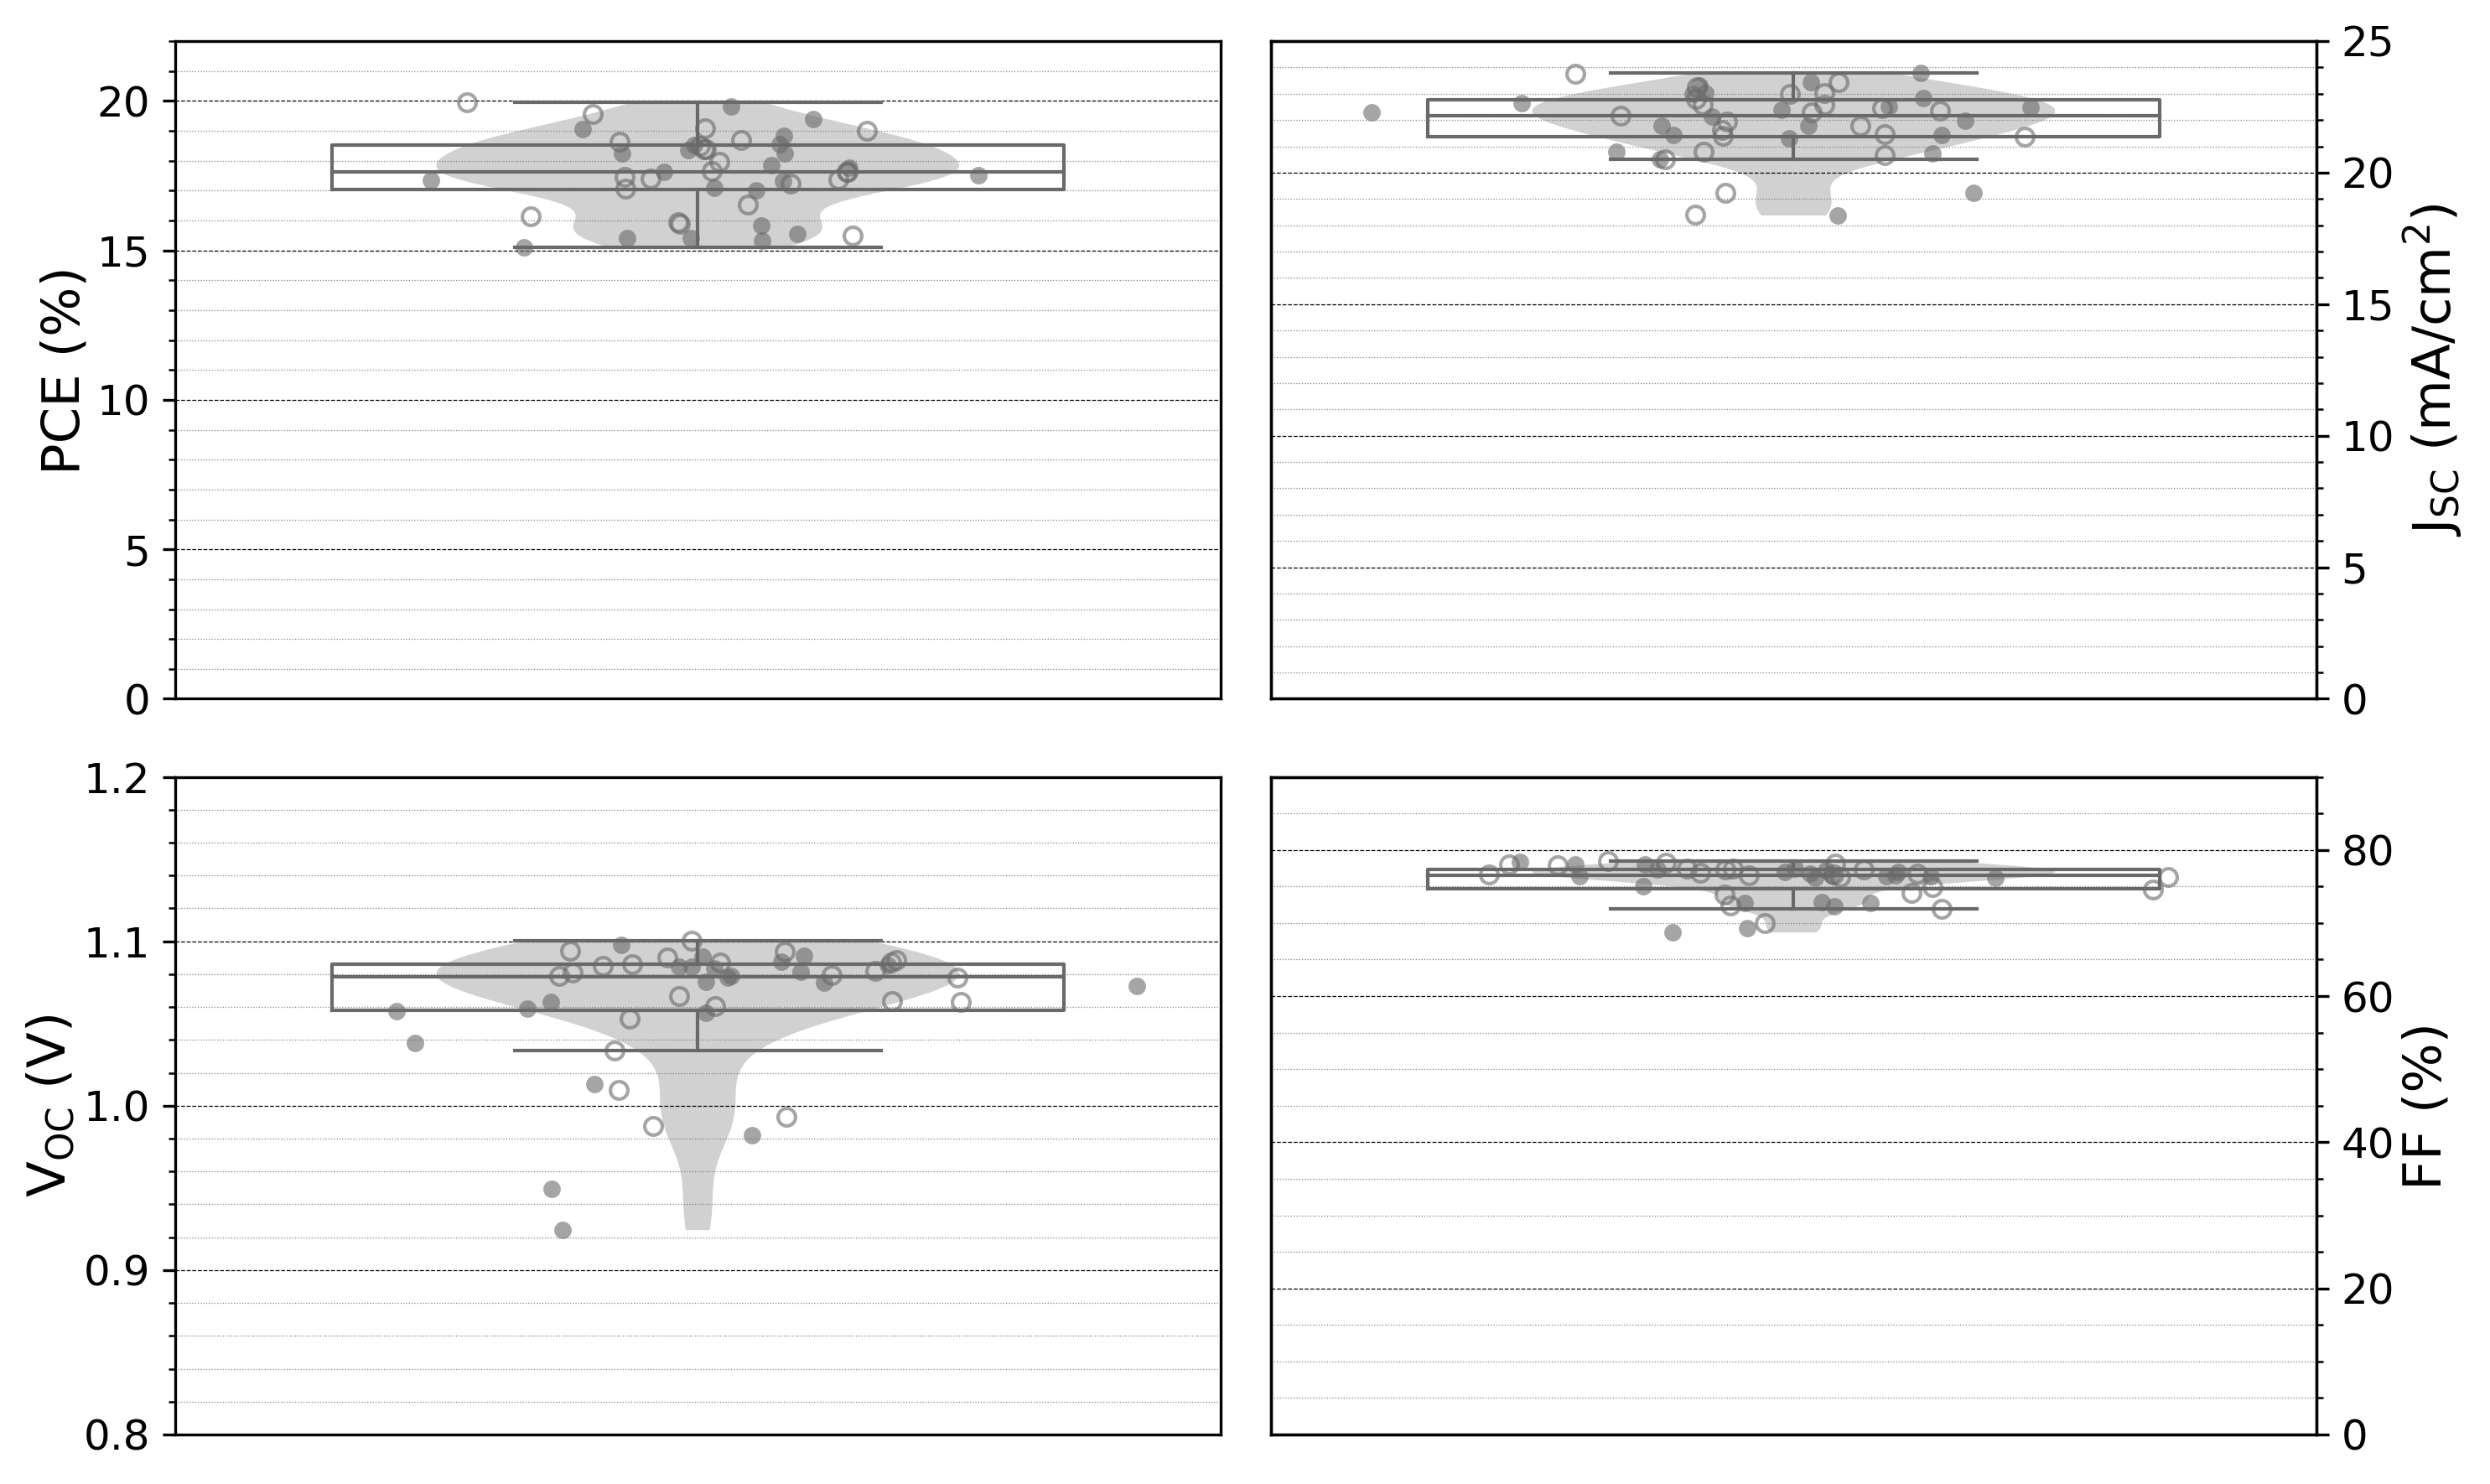

In [74]:
if plot_boxplots == 1:
        fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = 'col', figsize = (10, 6), dpi = 300) #creates new window
        
        groups_bplot('PCE', axes[0,0], 'PCE (%)')    
        groups_bplot('Jsc', axes[0,1],'$\mathregular{J_{SC}}$ (mA/$\mathregular{cm^{2})}$') 
        groups_bplot('Voc', axes[1,0],'$\mathregular{V_{OC}}$ (V)')   
        groups_bplot('FF', axes[1,1], 'FF (%)')

        fig.subplots_adjust(wspace = 0.05, hspace = 0.1)
        fig.tight_layout()
        plt.show()
                      
        if save_boxplots == 1:
            fig.savefig(cwd + '\\' + plot_title + '.png') #saves png figure to outplot plots folder, using substrate name
               
else:
    pass
 
if record_statistics_of_filtered_data == 1 and save_boxplots == 1:
    data_labels = ['PCE mean', 'PCE stdev', 'PCE champion', 'Jsc mean', 'Jsc stdev', 'Jsc champion', 'Voc mean', 'Voc stdev', 'Voc champion', 'FF mean', 'FF stdev', 'FF champion' ]
    if Groupnames == []:
        headers = [('Group' + str(x+1)) for x in range(0, int(Groups))]
    else:
        headers = Groupnames
    df = pd.DataFrame(groups_calculate_statistics('PCE'), columns = headers, index = data_labels[0:3])
    df = df.append(pd.DataFrame(groups_calculate_statistics('Jsc'), columns = headers, index = data_labels[3:6]))
    df = df.append(pd.DataFrame(groups_calculate_statistics('Voc'), columns = headers, index = data_labels[6:9]))
    df = df.append(pd.DataFrame(groups_calculate_statistics('FF'), columns = headers, index = data_labels[9:12]))
    # df = df.set_axis(data_labels, axis=0)
    df.to_csv(cwd + '\\' + plot_title + '.csv', )
